# Cart-Pole Agent Implementation

- This module defines an `Agent` class for interacting with the Cart-Pole environment using reinforcement learning techniques.

In [1]:
from typing import Any

import gymnasium as gym
import matplotlib.pyplot as plt  
import numpy as np

from keras.models import Sequential
from keras.layers import Activation, Dense  
from keras.optimizers import Adam  
from keras.utils import to_categorical  

## Implementation of Agent Class

In [2]:
class Agent:
    def __init__(self, env: gym.Env) -> None:
        self.env = env
        self.observations: int = self.env.observation_space.shape[0] # input layer
        self.actions: int = self.env.action_space.n # output layer
        self.model: Sequential = self.get_model() # neural network

    # Definition of the neural network model of the Agent[states -> actions]
    def get_model(self) -> Sequential:
        model = Sequential()
        model.add(Dense(100, input_shape=(self.observations,), activation="relu"))
        model.add(Dense(self.actions, activation="softmax"))
        model.compile(optimizer=Adam(learning_rate=0.007), 
                      loss="categorical_crossentropy", metrics=["accuracy"])
        return model

    # Select an action based on the current state using the NN model
    def get_action(self, state: Any) -> Any:
        state = state.reshape(1, -1) # reshape state for the model  
        # get action probabilities from the model i.e. [p(action_0), p(action_1), ...]
        policy = self.model(state, training=False).numpy()[0] 
        return np.random.choice(self.actions, p=policy)
    
    # Collect samples (episodes) by running the agent in the environment
    def get_samples(self, num_episodes: int) -> tuple[list[float], list[Any]]:
        # list of total rewards for all episodes
        rewards: list[float] = [0.0 for _ in range(num_episodes)]
        # list of episodes (state, action) pairs
        episodes: list[Any] = [[] for _ in range(num_episodes)]
        # collect samples by running the agent in the environment (play episodes)
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0.0
            while True:
                action = self.get_action(state)
                new_state, reward, done, truncated, _ = self.env.step(action)
                total_reward += reward
                episodes[episode].append((state, action))
                state = new_state
                if done or truncated:
                    rewards[episode] += total_reward
                    break
        return rewards, episodes
    
    # Filter the best episodes based on reward percentile
    def filter_episodes(self, rewards: list[float], episodes: list[tuple[float, float]], percentile: float) -> tuple[np.ndarray, np.ndarray, float]:
        # select episodes with rewards above the given percentile
        rewards_boundaries = float(np.percentile(rewards, percentile))
        x_train_: list[np.ndarray] = []
        y_train_: list[np.ndarray] = []
        for reward, episode in zip(rewards, episodes):
            if reward >= rewards_boundaries:
                for state, action in episode:
                    observation = [step[0] for step in episode]
                    action = [step[1] for step in episode]
                    x_train_.extend(observation)
                    y_train_.extend(action)
        x_train = np.asarray(x_train_)
        y_train = to_categorical(y_train_, num_classes=self.actions)
        return x_train, y_train, rewards_boundaries

    def train(self, percentile: float, num_iterations: int, num_episodes: int) -> tuple[list[float], list[float]]:
        rewards_means: list[float] = []
        rewards_boundaries: list[float] = []
        for iteration in range(num_iterations):
            rewards, episodes = self.get_samples(num_episodes) # collect samples
            # filter samples based on reward boundary (keep only best episodes)
            x_train, y_train, reward_boundary = self.filter_episodes(rewards, episodes, percentile)
            # train the model on the filtered samples
            self.model.train_on_batch(x_train, y_train)
            # compute mean reward for reporting
            reward_mean = float(np.mean(rewards))
            print(
                f"Iteration: {iteration:2d} "
                f"Reward Mean: {reward_mean:.4f} "
                f"Reward Bound: {reward_boundary:.4f}")
            # store metrics
            rewards_means.append(reward_mean)
            rewards_boundaries.append(reward_boundary)
        return rewards_means, rewards_boundaries
    
    # Play the environment using the trained agent
    def play(self, episodes: int, render: bool = True) -> None:
        for episode in range(episodes):
            state, _ = self.env.reset()
            total_reward = 0.0
            # Play one episode
            while True:
                if render:
                    self.env.render()
                action = self.get_action(state)
                state, reward, done, truncated, _ = self.env.step(action)
                total_reward += reward
                if done or truncated:
                    break

            print(f"Episode: {episode} Total Reward: {total_reward}")
        self.env.close()


## Initialize CartPole Environment and Agent

In [3]:
# Initialize the CartPole environment
env = gym.make("CartPole-v1")

# Initialize and train the agent
agent = Agent(env)

/Users/alex/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training Loop for the Agent

In [4]:
reward_means, reward_boundaries = agent.train(
    percentile=70, 
    num_iterations=30, 
    num_episodes=100)

Iteration:  0 Reward Mean: 23.0300 Reward Bound: 26.0000
Iteration:  1 Reward Mean: 26.1200 Reward Bound: 30.3000
Iteration:  2 Reward Mean: 33.4600 Reward Bound: 40.0000
Iteration:  3 Reward Mean: 35.2100 Reward Bound: 40.3000
Iteration:  4 Reward Mean: 37.2400 Reward Bound: 44.6000
Iteration:  5 Reward Mean: 42.6700 Reward Bound: 50.3000
Iteration:  6 Reward Mean: 46.4400 Reward Bound: 50.3000
Iteration:  7 Reward Mean: 52.9300 Reward Bound: 57.0000
Iteration:  8 Reward Mean: 52.6600 Reward Bound: 58.3000
Iteration:  9 Reward Mean: 63.7200 Reward Bound: 73.6000
Iteration: 10 Reward Mean: 60.0400 Reward Bound: 70.3000
Iteration: 11 Reward Mean: 66.0200 Reward Bound: 80.3000
Iteration: 12 Reward Mean: 71.3300 Reward Bound: 87.3000
Iteration: 13 Reward Mean: 70.0100 Reward Bound: 79.0000
Iteration: 14 Reward Mean: 77.6300 Reward Bound: 89.6000
Iteration: 15 Reward Mean: 88.0000 Reward Bound: 98.6000
Iteration: 16 Reward Mean: 95.4000 Reward Bound: 110.3000
Iteration: 17 Reward Mean: 100

## Visualizing Training Results

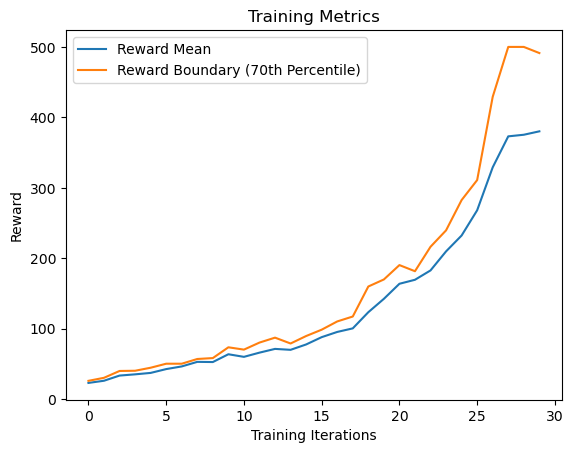

In [5]:
plt.title("Training Metrics")
plt.plot(range(len(reward_means)), reward_means, label="Reward Mean")
plt.plot(range(len(reward_boundaries)), reward_boundaries, label="Reward Boundary (70th Percentile)")
plt.xlabel("Training Iterations")
plt.ylabel("Reward")
plt.legend()
plt.show()

## Visualization of Playing the Environment by the Trained Agent

In [7]:
env = gym.make("CartPole-v1", render_mode="human")
trained_agent = Agent(env)
trained_agent.model = agent.model  # Use the trained model
trained_agent.model.summary()

/Users/alex/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,108 (8.24 KB)

 Trainable params: 702 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,406 (5.50 KB)

In [ ]:
trained_agent.play(episodes=1, render=True)

NameError: name 'trained_agent' is not defined